In [51]:
## Main Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msg
# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OrdinalEncoder, PowerTransformer
from sklearn_features.transformers import DataFrameSelector
## kmeans
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score


## scipy
from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
df=pd.read_csv("Mall_Customers.csv")

## Big Picture Of Data

In [3]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
# numerical columns
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [6]:
# caterogical columns
df.describe(include="object")

,Gender
count,200
unique,2
top,Female
freq,112


In [7]:
# check nulls
df.isna().sum().sort_values(ascending=False)

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

<AxesSubplot:>

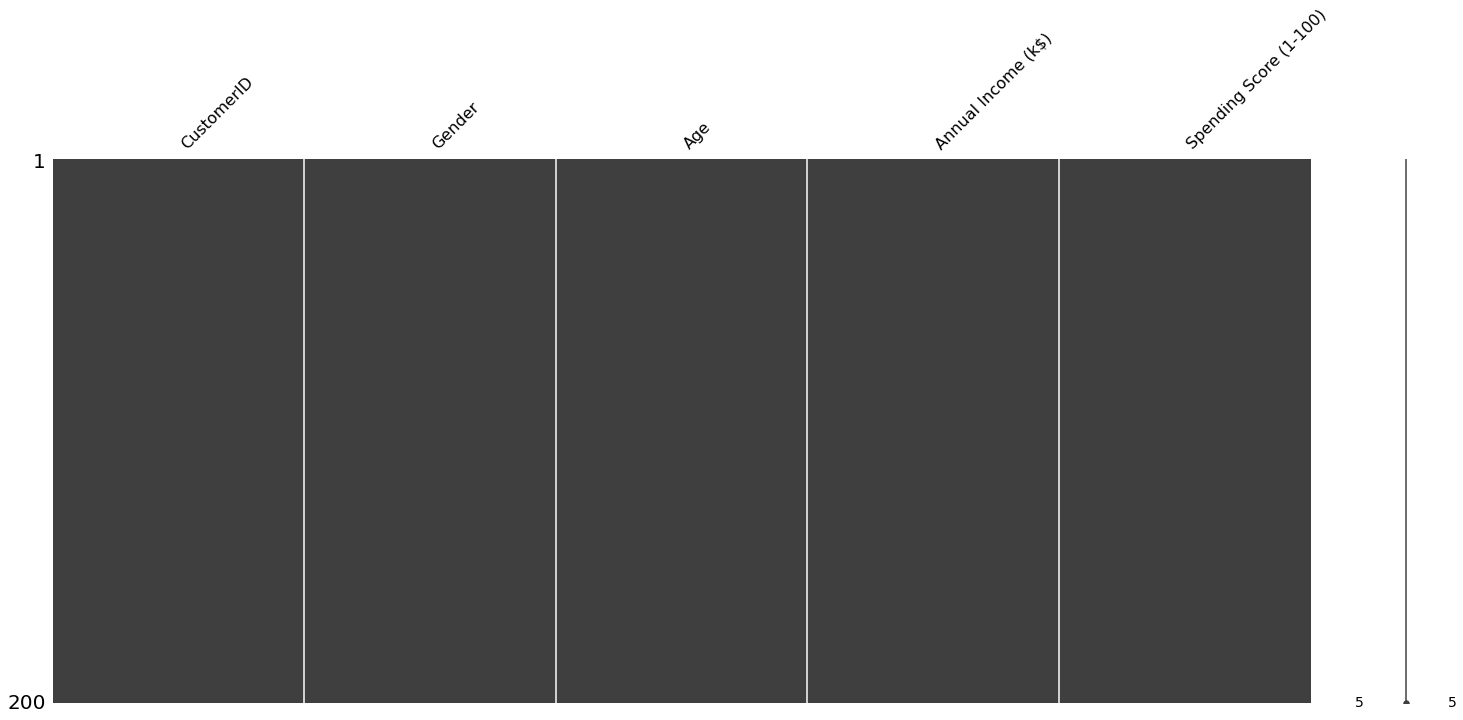

In [9]:
msg.matrix(df)

In [10]:
# check duplictes
df.duplicated().sum()

0

In [22]:
df=df.rename({"Annual Income (k$)":"Annual Income",'Spending Score (1-100)':"Spending Score"},axis=1)
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income', 'Spending Score'], dtype='object')

In [23]:
df.columns=df.columns.str.lower().str.replace(" ","_")

In [24]:
df.columns

Index(['customerid', 'gender', 'age', 'annual_income', 'spending_score'], dtype='object')

In [29]:
# i will drop customerid --> not important in insights
df.drop(columns="customerid",axis=1,inplace=True) 

# EDA

In [30]:
numerical_features=df.select_dtypes(include="number").columns.to_list()
caterogical_features=df.select_dtypes(exclude="number").columns.to_list()

In [31]:
numerical_features

['age', 'annual_income', 'spending_score']

In [32]:
caterogical_features

['gender']

## univariate analysis

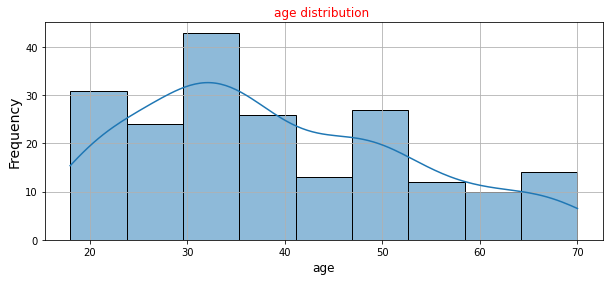

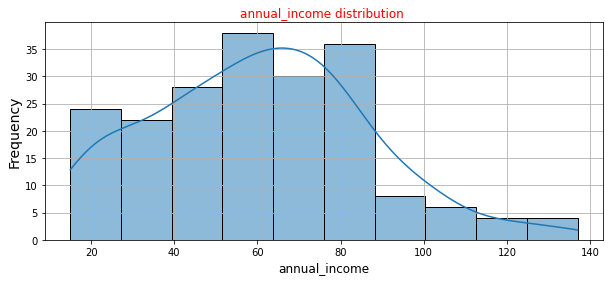

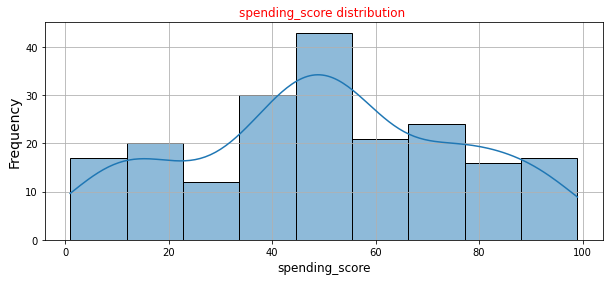

In [33]:
for feature in numerical_features:
    plt.figure(figsize=(10,4))
    sns.histplot(data=df,x=feature,palette="Oranges",kde=True)
    plt.xlabel(feature,fontsize=12,color="black")
    plt.ylabel("Frequency",fontsize=14,color="black")
    plt.title(f"{feature} distribution ",fontsize=12,color="red")
    plt.grid()
    plt.show()

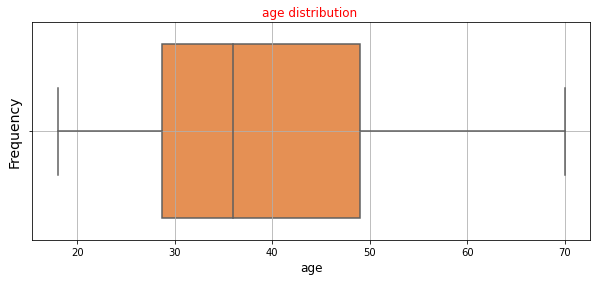

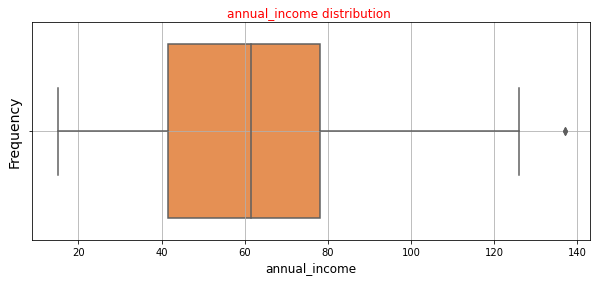

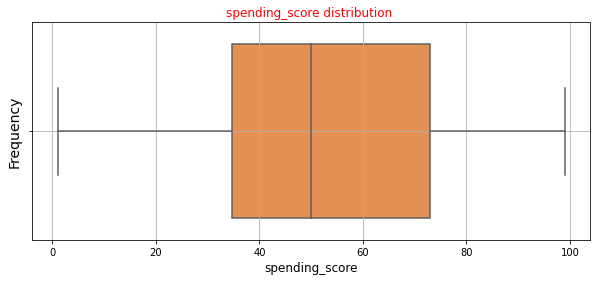

In [34]:
for feature in numerical_features:
    plt.figure(figsize=(10,4))
    sns.boxplot(data=df,x=feature,palette="Oranges")
    plt.xlabel(feature,fontsize=12,color="black")
    plt.ylabel("Frequency",fontsize=14,color="black")
    plt.title(f"{feature} distribution ",fontsize=12,color="red")
    plt.grid()
    plt.show()

* `no outlier in numerical features`

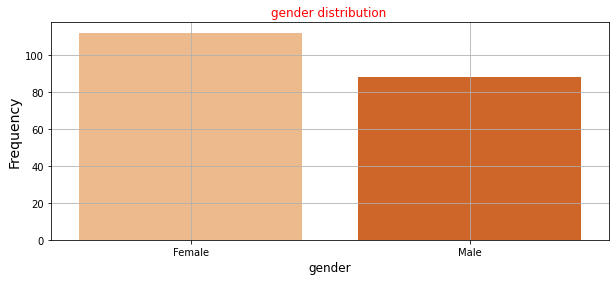

In [35]:
for feature in caterogical_features:
    plt.figure(figsize=(10,4))
    sns.countplot(data=df,x=feature,palette="Oranges",order=df[feature].value_counts().index)
    plt.xlabel(feature,fontsize=12,color="black")
    plt.ylabel("Frequency",fontsize=14,color="black")
    plt.title(f"{feature} distribution ",fontsize=12,color="red")
    plt.grid()
    plt.show()

## bivariate analysis

<Figure size 720x288 with 0 Axes>

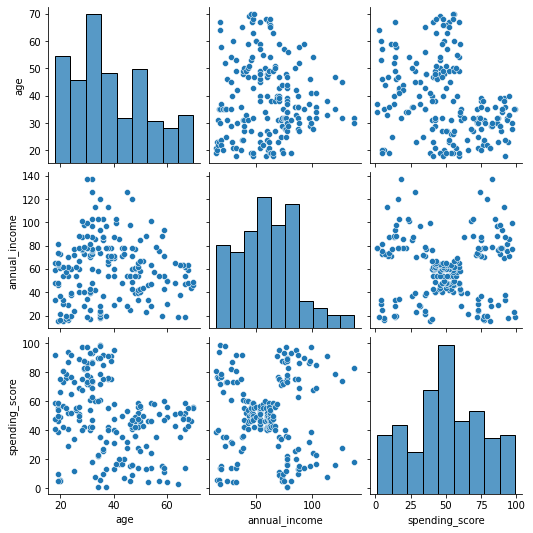

In [36]:
plt.figure(figsize=(10,4))
sns.pairplot(data=df[numerical_features])
plt.show()

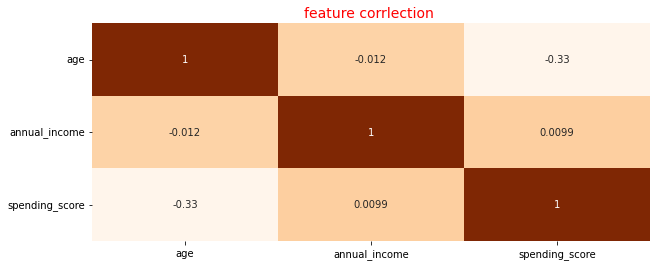

In [37]:
plt.figure(figsize=(10,4))
plt.title("feature corrlection ",fontsize=14,color="red")
sns.heatmap(df[numerical_features].corr(),annot=True,cbar=False,cmap="Oranges")
plt.show()

In [38]:
df.groupby(caterogical_features)[numerical_features].mean()

,age,annual_income,spending_score
gender,,,
Female,38.098214,59.250000,51.526786
Male,39.806818,62.227273,48.511364


In [41]:
px.box(data_frame=df,x="age",color="gender",color_discrete_sequence=px.colors.qualitative.Dark24_r)

In [42]:
px.box(data_frame=df,x="annual_income",color="gender",color_discrete_sequence=px.colors.qualitative.Dark24_r)

In [43]:
px.box(data_frame=df,x="spending_score",color="gender",color_discrete_sequence=px.colors.qualitative.Dark24_r)

In [45]:
px.scatter(data_frame=df,x="annual_income",y="age",color="gender",color_discrete_sequence=px.colors.qualitative.Dark24_r)

In [46]:
px.scatter(data_frame=df,x="annual_income",y="spending_score",color="gender",color_discrete_sequence=px.colors.qualitative.Dark24_r)

In [49]:
X_train=df

# Data preprocessing 

In [50]:
num_cols=X_train.select_dtypes(include="number").columns.to_list()
cat_cols=X_train.select_dtypes(exclude="number").columns.to_list()

In [52]:
cat_pipe=Pipeline(steps=[
    ("selector",DataFrameSelector(cat_cols)),
    ("impute",SimpleImputer(strategy="most_frequent")),
    ("encoder",OrdinalEncoder())
])
num_pipe=Pipeline(steps=[
    ("selector",DataFrameSelector(num_cols)),
    ("impute",SimpleImputer(strategy="mean")),
    ("tranform",PowerTransformer(standardize=True))
])
all_pipe=FeatureUnion(transformer_list=[
    ("caterogical_pipline",cat_pipe),
    ("numerical_pipline",num_pipe)
])
X_train=all_pipe.fit_transform(X_train)

# Buliding Models

In [53]:
kmeans = KMeans(n_clusters=5, n_init=10, random_state=45)
kmeans.fit(X_train)

KMeans(n_clusters=5, random_state=45)

In [54]:
kmeans.predict(X_train)

array([1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 4, 1, 4, 1,
       2, 1, 4, 1, 1, 1, 4, 1, 1, 4, 4, 4, 4, 4, 1, 4, 4, 1, 4, 4, 4, 1,
       4, 4, 1, 1, 4, 4, 4, 4, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 1, 4, 4, 1,
       1, 4, 4, 1, 4, 4, 1, 1, 4, 1, 4, 1, 1, 4, 4, 1, 4, 1, 4, 4, 4, 4,
       4, 1, 4, 1, 1, 1, 4, 4, 4, 4, 1, 4, 4, 3, 0, 3, 0, 3, 0, 3, 0, 3,
       0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 4, 3, 0, 3, 0, 3, 0, 3,
       0, 3, 0, 3, 0, 3, 4, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3,
       0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3,
       0, 3])

In [55]:
kmeans.inertia_

214.86132956952468

In [56]:
## Choose the optimal value of k for elbow method

k_choose = np.arange(2, 12, 1)

k_with_inertia = {}

for k in k_choose:
    each_kmeans = KMeans(n_clusters=k, n_init=10, random_state=45)
    each_kmeans.fit(X_train)
    
    ## Get interia
    k_with_inertia[k] = each_kmeans.inertia_

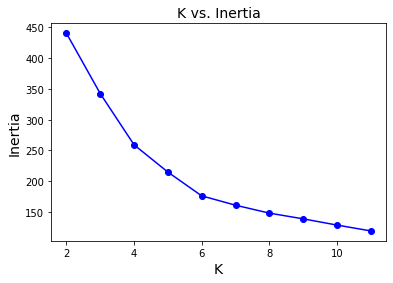

In [57]:
## Draw to get the best value for k 

plt.plot(k_with_inertia.keys(), k_with_inertia.values(), 'bo-')
plt.title('K vs. Inertia', fontsize=14)
plt.xlabel('K', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.show()   ## optimal according to elbow method that k=4

In [58]:
## Choose the optimal value of k for silhouete score

k_choose = np.arange(2, 12, 1)

k_with_score = {}
for k in k_choose:
    each_kmeans = KMeans(n_clusters=k, n_init=10, random_state=45)
    each_kmeans.fit(X_train)
    
    ## Get score
    k_with_score[k] = silhouette_score(X_train, each_kmeans.labels_)

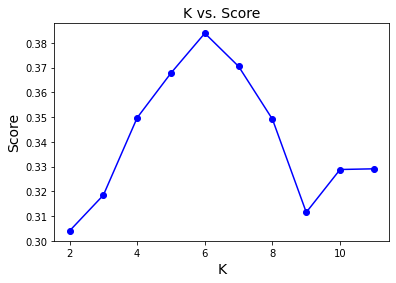

In [59]:
## Draw to get the best value for k 

plt.plot(k_with_score.keys(), k_with_score.values(), 'bo-')
plt.title('K vs. Score', fontsize=14)
plt.xlabel('K', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.show()   ## optimal according to silhouete score is also 4

In [61]:
## To dataframe
cluaster_no = kmeans.predict(X_train)



In [62]:
X_train.shape,cluaster_no.shape

((200, 4), (200,))

In [68]:
df_kmeans = pd.DataFrame(np.c_[X_train[:,[1,2]], cluaster_no], columns=['x1', 'x2', 'cluster_no'])
df_kmeans

,x1,x2,cluster_no
0,-1.718993,-1.989930,1.0
1,-1.470002,-1.989930,1.0
2,-1.591912,-1.930366,2.0
3,-1.240020,-1.930366,1.0
4,-0.461118,-1.872032,2.0
...,...,...,...
195,-0.133840,2.027774,3.0
196,0.563320,2.202670,0.0
197,-0.376090,2.202670,3.0
198,-0.376090,2.515898,0.0


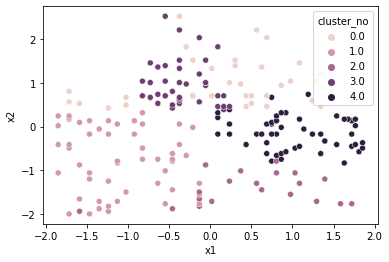

In [70]:
sns.scatterplot(data=df_kmeans, x='x1', y='x2', hue='cluster_no')
plt.show()

### `DBSCAN`

In [73]:
## Train DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X_train)

DBSCAN()

In [74]:
## To get predict of X
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64)

In [75]:
df_dbscan = pd.DataFrame(np.c_[np.c_[X_train[:,[1,2]]], dbscan.labels_], columns=['x1', 'x2', 'cluster_no'])
df_dbscan

,x1,x2,cluster_no
0,-1.718993,-1.989930,-1.0
1,-1.470002,-1.989930,-1.0
2,-1.591912,-1.930366,-1.0
3,-1.240020,-1.930366,-1.0
4,-0.461118,-1.872032,-1.0
...,...,...,...
195,-0.133840,2.027774,-1.0
196,0.563320,2.202670,-1.0
197,-0.376090,2.202670,-1.0
198,-0.376090,2.515898,-1.0


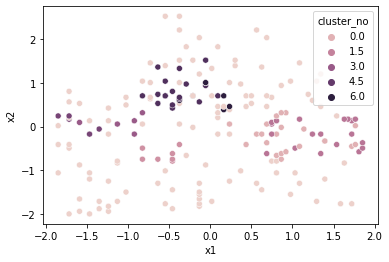

In [76]:
sns.scatterplot(data=df_dbscan, x='x1', y='x2', hue='cluster_no')
plt.show()

### `H. Clustering`

In [81]:
## using sklearn
cluster_sklearn = AgglomerativeClustering(n_clusters=7, linkage='ward')
cluster_sklearn.fit(pd.DataFrame(X_train).values)

AgglomerativeClustering(n_clusters=7)

In [82]:
df_H = pd.DataFrame(np.c_[np.c_[X_train[:,[1,2]]], cluster_sklearn.labels_], columns=['x1', 'x2', 'cluster_no'])
df_H

,x1,x2,cluster_no
0,-1.718993,-1.989930,1.0
1,-1.470002,-1.989930,5.0
2,-1.591912,-1.930366,1.0
3,-1.240020,-1.930366,5.0
4,-0.461118,-1.872032,1.0
...,...,...,...
195,-0.133840,2.027774,2.0
196,0.563320,2.202670,3.0
197,-0.376090,2.202670,2.0
198,-0.376090,2.515898,3.0


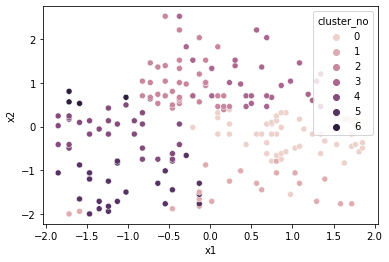

In [83]:
sns.scatterplot(data=df_H, x='x1', y='x2', hue='cluster_no')
plt.show()